In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Step 1: Install required libraries
!pip install datasets seqeval torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=2107b132858b9a961d4bb0293a220abf3949e93ab45805f84f40713350b24beb
  Stor

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

## Load the dataset

In [4]:
from datasets import load_dataset
dataset = load_dataset("conll2003", trust_remote_code=True)

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [5]:
df = dataset["train"].to_pandas()
df.head()

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


# Preprocessing

In [6]:
# Build vocabulary from training data
word_counts = defaultdict(int)
for sentence in dataset['train']['tokens']:
    for token in sentence:
        word_counts[token] += 1

vocab = ['<PAD>', '<UNK>'] + sorted(word_counts.keys())
word2idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

# Get tag names
ner_feature = dataset['train'].features['ner_tags']
tag_names = ner_feature.feature.names
num_tags = len(tag_names)
print(tag_names)

# Determine max sequence length (capped at 128 for memory)
max_len = 128

# Function to process data
def process_data(split, word2idx, max_len):
    token_indices = []
    tag_indices = []
    for tokens, tags in zip(split['tokens'], split['ner_tags']):
        # Truncate/pad tokens
        tokens_trunc = tokens[:max_len]
        tok_idx = [word2idx.get(token, 1) for token in tokens_trunc]
        tok_padded = tok_idx + [0]*(max_len - len(tok_idx))
        token_indices.append(tok_padded)
        
        # Process tags
        tags_trunc = tags[:max_len]
        tag_padded = tags_trunc + [-100]*(max_len - len(tags_trunc))
        tag_indices.append(tag_padded)
    
    return torch.LongTensor(token_indices), torch.LongTensor(tag_indices)

# Process all splits
train_tokens, train_tags = process_data(dataset['train'], word2idx, max_len)
val_tokens, val_tags = process_data(dataset['validation'], word2idx, max_len)
test_tokens, test_tags = process_data(dataset['test'], word2idx, max_len)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [6]:
# Vectorization
# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(train_tokens, train_tags)
val_dataset = TensorDataset(val_tokens, val_tags)
test_dataset = TensorDataset(test_tokens, test_tags)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 1: Train Loss: 0.678, Val Loss: 0.607
Epoch 2: Train Loss: 0.496, Val Loss: 0.500
Epoch 3: Train Loss: 0.409, Val Loss: 0.426
Epoch 4: Train Loss: 0.355, Val Loss: 0.375
Epoch 5: Train Loss: 0.314, Val Loss: 0.377
Epoch 6: Train Loss: 0.285, Val Loss: 0.369
Epoch 7: Train Loss: 0.260, Val Loss: 0.353
Epoch 8: Train Loss: 0.242, Val Loss: 0.326
Epoch 9: Train Loss: 0.225, Val Loss: 0.325
Epoch 10: Train Loss: 0.211, Val Loss: 0.342
Epoch 11: Train Loss: 0.198, Val Loss: 0.358
Epoch 12: Train Loss: 0.189, Val Loss: 0.358
Epoch 13: Train Loss: 0.180, Val Loss: 0.319
Epoch 14: Train Loss: 0.171, Val Loss: 0.328
Epoch 15: Train Loss: 0.164, Val Loss: 0.331
Epoch 16: Train Loss: 0.156, Val Loss: 0.336
Epoch 17: Train Loss: 0.150, Val Loss: 0.324
Epoch 18: Train Loss: 0.146, Val Loss: 0.345
Epoch 19: Train Loss: 0.141, Val Loss: 0.338
Epoch 20: Train Loss: 0.137, Val Loss: 0.337
Epoch 21: Train Loss: 0.132, Val Loss: 0.343
Epoch 22: Train Loss: 0.129, Val Loss: 0.351
Epoch 23: Train Los

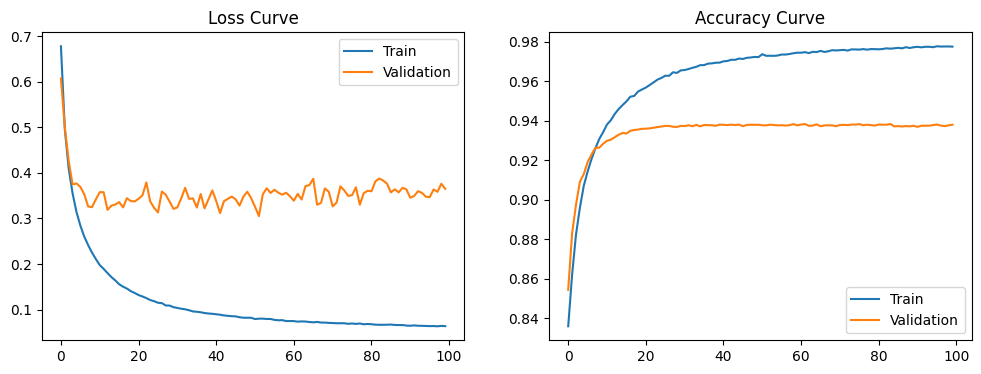

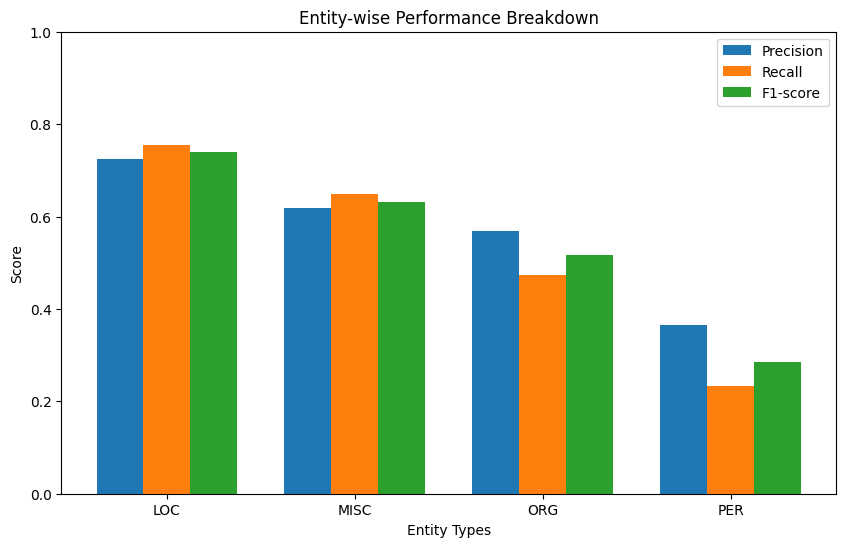

Overall F1: 0.546
Overall Precision: 0.588
Overall Recall: 0.509


In [22]:
# Cell 2: LSTM Model Training & Evaluation
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report

# Model Definition
class NERModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                           bidirectional=True, dropout=dropout if n_layers>1 else 0)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, _ = self.lstm(embedded)
        return self.fc(self.dropout(output))

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NERModel(vocab_size, 100, 256, num_tags, 2, 0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Training Loop
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(100):  
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=2)
        mask = labels != -100
        correct += preds[mask].eq(labels[mask]).sum().item()
        total += mask.sum().item()
    
    # Validation
    model.eval()
    val_total_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_total_loss += criterion(outputs.view(-1, num_tags), labels.view(-1)).item()
            preds = outputs.argmax(dim=2)
            mask = labels != -100
            val_correct += preds[mask].eq(labels[mask]).sum().item()
            val_total += mask.sum().item()
    
    # Store metrics
    train_loss.append(total_loss/len(train_loader))
    train_acc.append(correct/total)
    val_loss.append(val_total_loss/len(val_loader))
    val_acc.append(val_correct/val_total)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss[-1]:.3f}, Val Loss: {val_loss[-1]:.3f}")

# Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Entity Performance Visualization
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).argmax(dim=2).cpu().numpy()
        labels = labels.numpy()
        
        for i in range(len(inputs)):
            seq_len = (labels[i] != -100).sum()
            pred_tags = [tag_names[outputs[i][j]] for j in range(seq_len)]
            true_tags = [tag_names[labels[i][j]] for j in range(seq_len)]
            all_preds.append(pred_tags)
            all_labels.append(true_tags)

# Generate and plot entity metrics
report = classification_report(all_labels, all_preds, output_dict=True)
entities = ['LOC', 'MISC', 'ORG', 'PER']
metrics = ['precision', 'recall', 'f1-score']

plt.figure(figsize=(10, 6))
x = np.arange(len(entities))
width = 0.25

for i, metric in enumerate(metrics):
    scores = [report[ent][metric] for ent in entities]
    plt.bar(x + i*width, scores, width, label=metric.capitalize())

plt.title('Entity-wise Performance Breakdown')
plt.xlabel('Entity Types')
plt.ylabel('Score')
plt.xticks(x + width, entities)
plt.ylim(0, 1)
plt.legend()
plt.show()

print(f"Overall F1: {report['micro avg']['f1-score']:.3f}")
print(f"Overall Precision: {report['micro avg']['precision']:.3f}")
print(f"Overall Recall: {report['micro avg']['recall']:.3f}")

In [21]:
# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).argmax(dim=2).cpu().numpy()
        labels = labels.numpy()
        
        for i in range(len(inputs)):
            seq_len = (labels[i] != -100).sum()
            pred_tags = [tag_names[outputs[i][j]] for j in range(seq_len)]
            true_tags = [tag_names[labels[i][j]] for j in range(seq_len)]
            all_preds.append(pred_tags)
            all_labels.append(true_tags)

print(classification_report(all_labels, all_preds, mode='strict', scheme=IOB2))

              precision    recall  f1-score   support

         LOC       0.77      0.75      0.76      1668
        MISC       0.69      0.61      0.65       702
         ORG       0.67      0.40      0.50      1661
         PER       0.29      0.15      0.20      1617

   micro avg       0.64      0.46      0.53      5648
   macro avg       0.61      0.48      0.53      5648
weighted avg       0.60      0.46      0.51      5648



Epoch 1:
Train Loss: 0.740 | Val Loss: 0.675
Train Acc: 0.832 | Val Acc: 0.843

Epoch 2:
Train Loss: 0.565 | Val Loss: 0.523
Train Acc: 0.846 | Val Acc: 0.861

Epoch 3:
Train Loss: 0.448 | Val Loss: 0.462
Train Acc: 0.865 | Val Acc: 0.877

Epoch 4:
Train Loss: 0.376 | Val Loss: 0.412
Train Acc: 0.883 | Val Acc: 0.890

Epoch 5:
Train Loss: 0.328 | Val Loss: 0.360
Train Acc: 0.896 | Val Acc: 0.902

Epoch 6:
Train Loss: 0.288 | Val Loss: 0.352
Train Acc: 0.908 | Val Acc: 0.911

Epoch 7:
Train Loss: 0.257 | Val Loss: 0.368
Train Acc: 0.919 | Val Acc: 0.910

Epoch 8:
Train Loss: 0.229 | Val Loss: 0.319
Train Acc: 0.928 | Val Acc: 0.920

Epoch 9:
Train Loss: 0.210 | Val Loss: 0.286
Train Acc: 0.935 | Val Acc: 0.927

Epoch 10:
Train Loss: 0.191 | Val Loss: 0.284
Train Acc: 0.941 | Val Acc: 0.928

Epoch 11:
Train Loss: 0.174 | Val Loss: 0.310
Train Acc: 0.946 | Val Acc: 0.934

Epoch 12:
Train Loss: 0.161 | Val Loss: 0.312
Train Acc: 0.951 | Val Acc: 0.933

Epoch 13:
Train Loss: 0.148 | Val Los

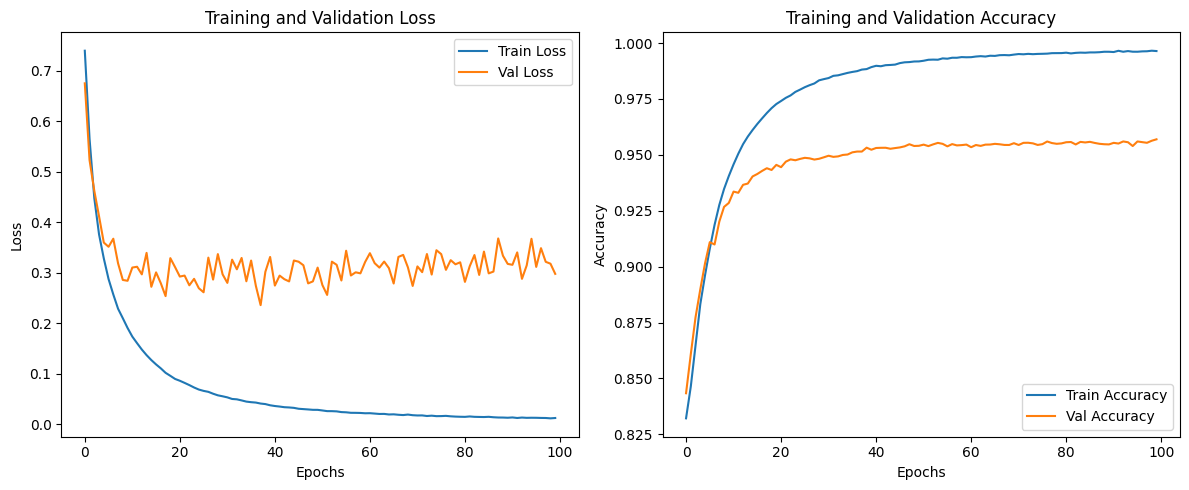

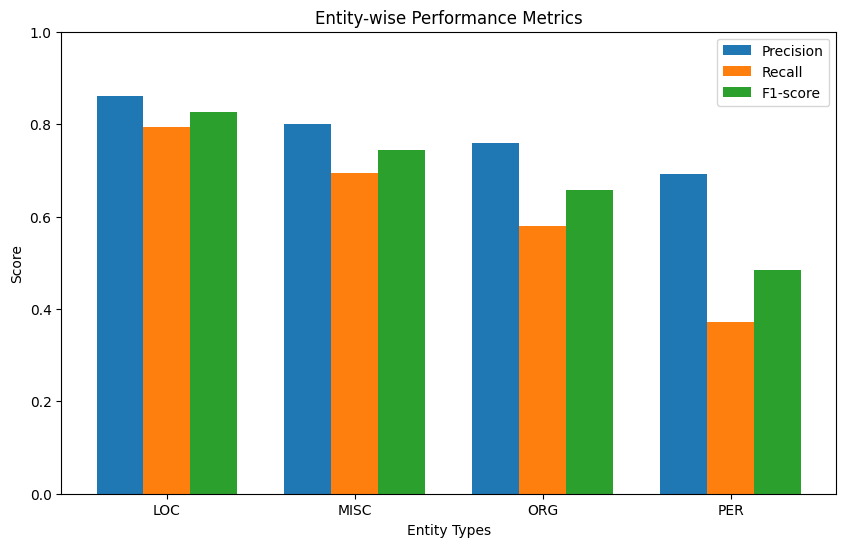

Test F1-score: 0.680
Test Precision: 0.788
Test Recall: 0.598


In [18]:
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report

# Improved CNN-BiLSTM-Attention Model with Plotting
class ImprovedNER(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.lstm = nn.LSTM(64, hidden_dim, num_layers=n_layers,
                           bidirectional=True, dropout=dropout if n_layers>1 else 0)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim*2, num_heads=4)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        cnn_features = self.cnn(embedded.permute(0, 2, 1)).permute(0, 2, 1)
        lstm_out, _ = self.lstm(cnn_features)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        return self.fc(self.dropout(attn_out))

# Initialize model
improved_model = ImprovedNER(vocab_size, 100, 256, num_tags, 2, 0.3).to(device)
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Training with progress tracking
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(100):
    improved_model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = improved_model(inputs)
        loss = criterion(outputs.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        preds = outputs.argmax(dim=2)
        mask = labels != -100
        correct_train += preds[mask].eq(labels[mask]).sum().item()
        total_train += mask.sum().item()
    
    # Validation phase
    improved_model.eval()
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = improved_model(inputs)
            epoch_val_loss += criterion(outputs.view(-1, num_tags), labels.view(-1)).item()
            
            preds = outputs.argmax(dim=2)
            mask = labels != -100
            correct_val += preds[mask].eq(labels[mask]).sum().item()
            total_val += mask.sum().item()
    
    # Store metrics
    train_loss = epoch_train_loss/len(train_loader)
    val_loss = epoch_val_loss/len(val_loader)
    train_acc = correct_train/total_train
    val_acc = correct_val/total_val
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}:")
    print(f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")
    print(f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}\n")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation and metric visualization
improved_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = improved_model(inputs).argmax(dim=2).cpu().numpy()
        labels = labels.numpy()
        
        for i in range(len(inputs)):
            seq_len = (labels[i] != -100).sum()
            pred_tags = [tag_names[outputs[i][j]] for j in range(seq_len)]
            true_tags = [tag_names[labels[i][j]] for j in range(seq_len)]
            all_preds.append(pred_tags)
            all_labels.append(true_tags)

# Generate classification report
report = classification_report(all_labels, all_preds, 
                              mode='strict', scheme=IOB2, output_dict=True)
entities = ['LOC', 'MISC', 'ORG', 'PER']
metrics = ['precision', 'recall', 'f1-score']

# Plot entity performance
plt.figure(figsize=(10, 6))
x = np.arange(len(entities))
width = 0.25

for i, metric in enumerate(metrics):
    values = [report[ent][metric] for ent in entities]
    plt.bar(x + i*width, values, width, label=metric.capitalize())

plt.title('Entity-wise Performance Metrics')
plt.xlabel('Entity Types')
plt.ylabel('Score')
plt.xticks(x + width, entities)
plt.ylim(0, 1)
plt.legend()
plt.show()

# Print final scores
print(f"Test F1-score: {report['micro avg']['f1-score']:.3f}")
print(f"Test Precision: {report['micro avg']['precision']:.3f}")
print(f"Test Recall: {report['micro avg']['recall']:.3f}")